In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
sns.set_style('darkgrid')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
olist_customer = pd.read_csv('/content/drive/MyDrive/olist_customers_dataset.csv')
olist_geolocation = pd.read_csv('/content/drive/MyDrive/olist_geolocation_dataset.csv')
olist_orders = pd.read_csv('/content/drive/MyDrive/olist_orders_dataset.csv')
olist_order_items = pd.read_csv('/content/drive/MyDrive/olist_order_items_dataset.csv')
olist_order_payments = pd.read_csv('/content/drive/MyDrive/olist_order_payments_dataset.csv')
olist_order_reviews = pd.read_csv('/content/drive/MyDrive/olist_order_reviews_dataset.csv')
olist_products = pd.read_csv('/content/drive/MyDrive/olist_products_dataset.csv')
olist_sellers = pd.read_csv('/content/drive/MyDrive/olist_sellers_dataset.csv')
olist_products_translation = pd.read_csv('/content/drive/MyDrive/product_category_name_translation.csv')

In [ ]:
datasets = [olist_customer, olist_geolocation, olist_orders, olist_order_items, olist_order_payments,
            olist_order_reviews, olist_products, olist_sellers, olist_products_translation]
names = ['olist_customer', 'olist_geolocation', 'olist_orders', 'olist_order_items', 'olist_order_payments',
         'olist_order_reviews', 'olist_products', 'olist_sellers', 'olist_products_translation']

# Creating a DataFrame with useful information about all datasets
data_info = pd.DataFrame()
data_info['dataset'] = names
data_info['n_rows'] = [df.shape[0] for df in datasets]
data_info['n_cols'] = [df.shape[1] for df in datasets]
data_info['total_null'] = [df.isnull().sum().sum() for df in datasets]
data_info['qty_null_columns'] = [len([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]
data_info['null_columns'] = [', '.join([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]

data_info.style.background_gradient()

,dataset,n_rows,n_cols,total_null,qty_null_columns,null_columns
0,olist_customer,99441,5,0,0,
1,olist_geolocation,1000163,5,0,0,
2,olist_orders,99441,8,4908,3,"order_approved_at, order_delivered_carrier_date, order_delivered_customer_date"
3,olist_order_items,112650,7,0,0,
4,olist_order_payments,103886,5,0,0,
5,olist_order_reviews,100000,7,146532,2,"review_comment_title, review_comment_message"
6,olist_products,32951,9,2448,8,"product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm"
7,olist_sellers,3095,4,0,0,
8,olist_products_translation,71,2,0,0,


In [ ]:
olist_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


#### Filtering only delivered status

In [ ]:
order_deliver = olist_orders[olist_orders['order_status'] == 'delivered']
order_deliver.isnull().sum()

order_id                          0
customer_id                       0
order_status                      0
order_purchase_timestamp          0
order_approved_at                14
order_delivered_carrier_date      2
order_delivered_customer_date     8
order_estimated_delivery_date     0
dtype: int64

- Has null values for approval date, delivery date. So, dropping null values.

In [ ]:
order_deliver = order_deliver.dropna()

#### Feature Engineer - Lead Time for every order(in hrs)
- Lead Time is basically time between placing an order and receiving it.
- Measuring it in hours.

In [ ]:
order_deliver['Lead'] = (pd.to_datetime(order_deliver['order_delivered_customer_date']) - pd.to_datetime(order_deliver['order_approved_at'])).astype('timedelta64[h]')
order_deliver.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,Lead
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,202.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,300.0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,225.0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,316.0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,67.0


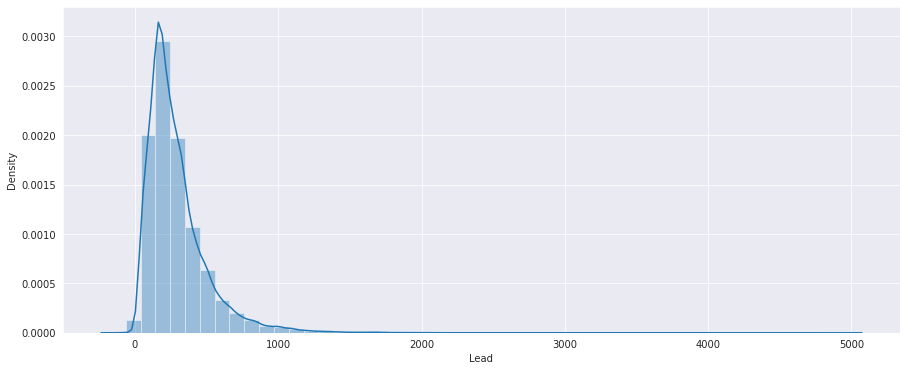

In [ ]:
plt.figure(figsize=(15,6))
sns.distplot(order_deliver['Lead']);

- Has negative values, could be data entry issue. So, dropping negative lead time.

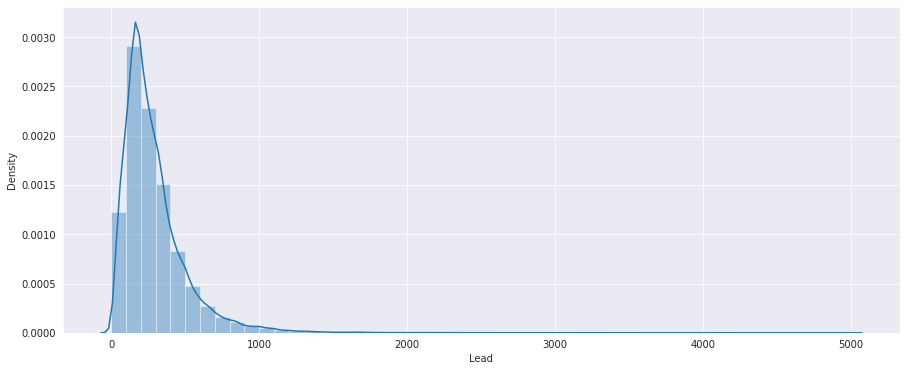

In [ ]:
order_deliver = order_deliver[order_deliver['Lead'] > 0]
plt.figure(figsize=(15,6))
sns.distplot(order_deliver['Lead']);

- Most of the orders are delivered within 10 days.

#### Overall Lead time average across all the orders

In [ ]:
order_deliver = order_deliver.sort_values('order_approved_at')
order_deliver

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,Lead
30710,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04 00:00:00,1315.0
64058,1ff217aa612f6cd7c4255c9bfe931c8b,b3a9bf200375f53cc5c6991919c356fd,delivered,2016-10-04 09:16:33,2016-10-04 09:43:32,2016-10-21 16:33:45,2016-10-24 16:33:45,2016-11-24 00:00:00,486.0
6747,cd3b8574c82b42fc8129f6d502690c3e,7812fcebfc5e8065d31e1bb5f0017dae,delivered,2016-10-03 22:31:31,2016-10-04 10:19:23,2016-10-08 10:34:01,2016-10-14 16:08:00,2016-11-23 00:00:00,245.0
67037,ed8c7b1b3eb256c70ce0c74231e1da88,da0ba2a9935bca5b4610b0e3bca9d3b4,delivered,2016-10-04 09:59:03,2016-10-04 10:25:46,2016-11-11 15:29:14,2016-11-18 08:51:07,2016-11-24 00:00:00,1078.0
88472,d207cc272675637bfed0062edffd0818,b8cf418e97ae795672d326288dfab7a7,delivered,2016-10-03 22:06:03,2016-10-04 10:28:07,2016-10-21 14:23:37,2016-10-31 11:07:42,2016-11-23 00:00:00,648.0
...,...,...,...,...,...,...,...,...,...
99369,52018484704db3661b98ce838612b507,e450a297a7bc6839ceb0cf1a2377fa02,delivered,2018-08-29 12:25:59,2018-08-29 12:35:17,2018-08-29 13:38:00,2018-08-30 22:48:27,2018-09-03 00:00:00,34.0
31486,168626408cb32af0ffaf76711caae1dc,6e353700bc7bcdf6ebc15d6de16d7002,delivered,2018-08-29 14:18:28,2018-08-29 14:30:23,2018-08-29 18:51:00,2018-08-30 16:52:31,2018-09-11 00:00:00,26.0
30077,0b223d92c27432930dfe407c6aea3041,e60df9449653a95af4549bbfcb18a6eb,delivered,2018-08-29 14:18:23,2018-08-29 14:31:07,2018-08-29 15:29:00,2018-08-30 16:24:55,2018-09-04 00:00:00,25.0
69678,03ef5dedbe7492bdae72eec50764c43f,496630b6740bcca28fce9ba50d8a26ef,delivered,2018-08-29 14:52:00,2018-08-29 15:05:22,2018-08-29 20:01:00,2018-08-30 16:36:59,2018-09-03 00:00:00,25.0


In [ ]:
delivery_days_average = order_deliver.groupby(pd.to_datetime(order_deliver['order_approved_at']).dt.date)['Lead'].mean()
delivery_days_average

order_approved_at
2016-09-15    1315.000000
2016-10-04     576.764706
2016-10-05     644.142857
2016-10-06     520.989247
2016-10-07     425.130435
                 ...     
2018-08-25     105.925926
2018-08-26      81.200000
2018-08-27      57.796875
2018-08-28      45.392857
2018-08-29      31.933333
Name: Lead, Length: 609, dtype: float64

In [ ]:
average_lead = round(delivery_days_average.mean(),2)
print('On Average, the Lead time of all the orders is',average_lead)

On Average, the Lead time of all the orders is 292.79


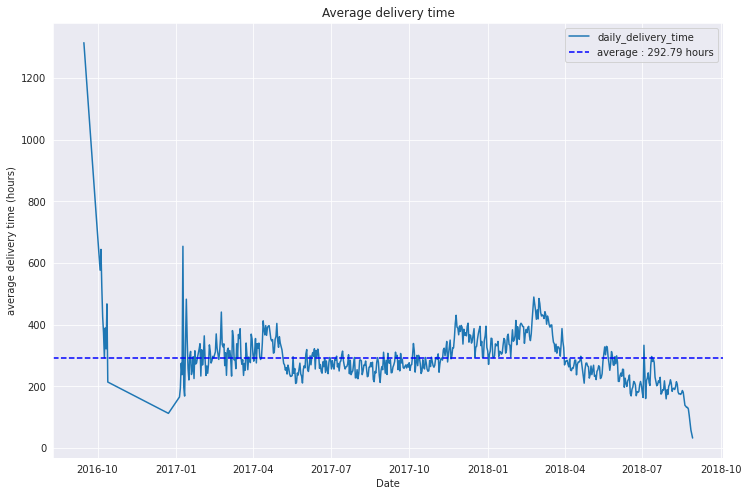

In [ ]:
plt.figure(figsize = (12,8))
plt.plot(delivery_days_average.index, delivery_days_average, label = 'daily_delivery_time')
plt.axhline(y=average_lead, linestyle='--', color='blue', label = 'average : ' + str(average_lead) + ' hours')
plt.xlabel('Date')
plt.ylabel('average delivery time (hours)')
plt.title('Average delivery time')
plt.legend(loc='best')
plt.show()

In [ ]:
items_seller = pd.merge(olist_order_items, olist_sellers, on='seller_id')
order_items_seller = pd.merge(items_seller,order_deliver, on='order_id')
order_items_seller.sort_values('order_purchase_timestamp')

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,seller_zip_code_prefix,seller_city,seller_state,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,Lead
90324,bfbd0f9bdef84302105ad712db648a6c,2,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,44.99,2.83,81810,curitiba,PR,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04 00:00:00,1315.0
90323,bfbd0f9bdef84302105ad712db648a6c,1,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,44.99,2.83,81810,curitiba,PR,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04 00:00:00,1315.0
90325,bfbd0f9bdef84302105ad712db648a6c,3,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,44.99,2.83,81810,curitiba,PR,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04 00:00:00,1315.0
52882,3b697a20d9e427646d92567910af6d57,1,3ae08df6bcbfe23586dd431c40bddbb7,522620dcb18a6b31cd7bdf73665113a9,2016-10-21 16:27:20,29.90,15.56,85801,cascavel,PR,355077684019f7f60a031656bd7262b8,delivered,2016-10-03 09:44:50,2016-10-06 15:50:54,2016-10-23 14:02:13,2016-10-26 14:02:13,2016-10-27 00:00:00,478.0
109902,be5bc2f0da14d8071e2d45451ad119d9,1,fd7fd78fd3cbc1b0a6370a7909c0a629,f09b760d23495ac9a7e00d29b769007c,2016-10-21 16:33:46,21.90,17.19,15802,catanduva,SP,7ec40b22510fdbea1b08921dd39e63d8,delivered,2016-10-03 16:56:50,2016-10-06 16:03:44,2016-10-21 16:33:46,2016-10-27 18:19:38,2016-11-07 00:00:00,506.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97561,0b223d92c27432930dfe407c6aea3041,1,2b4472df15512a2825ae86fd9ae79335,67bf6941ba2f1fa1d02c375766bc3e53,2018-08-31 14:30:19,209.00,46.48,82400,curitiba,PR,e60df9449653a95af4549bbfcb18a6eb,delivered,2018-08-29 14:18:23,2018-08-29 14:31:07,2018-08-29 15:29:00,2018-08-30 16:24:55,2018-09-04 00:00:00,25.0
97562,0b223d92c27432930dfe407c6aea3041,2,2b4472df15512a2825ae86fd9ae79335,67bf6941ba2f1fa1d02c375766bc3e53,2018-08-31 14:30:19,209.00,46.48,82400,curitiba,PR,e60df9449653a95af4549bbfcb18a6eb,delivered,2018-08-29 14:18:23,2018-08-29 14:31:07,2018-08-29 15:29:00,2018-08-30 16:24:55,2018-09-04 00:00:00,25.0
17994,168626408cb32af0ffaf76711caae1dc,1,bdcf6a834e8faa30dac3886c7a58e92e,2a84855fd20af891be03bc5924d2b453,2018-08-31 14:30:23,45.90,15.39,30111,belo horizonte,MG,6e353700bc7bcdf6ebc15d6de16d7002,delivered,2018-08-29 14:18:28,2018-08-29 14:30:23,2018-08-29 18:51:00,2018-08-30 16:52:31,2018-09-11 00:00:00,26.0
54233,03ef5dedbe7492bdae72eec50764c43f,1,c7f27c5bef2338541c772b5776403e6a,7d7866a99a8656a42c7ff6352a433410,2018-08-31 15:05:22,24.90,8.33,1320,sao paulo,SP,496630b6740bcca28fce9ba50d8a26ef,delivered,2018-08-29 14:52:00,2018-08-29 15:05:22,2018-08-29 20:01:00,2018-08-30 16:36:59,2018-09-03 00:00:00,25.0


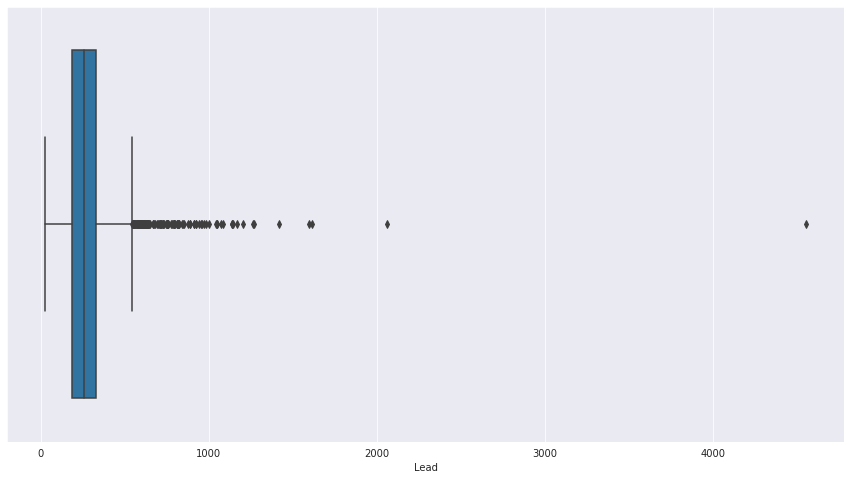

In [ ]:
plt.figure(figsize=(15,8))
sns.boxplot(order_items_seller.groupby('seller_id')['Lead'].mean().sort_values())
plt.show()

#### Feature Engineering 
- compute distance(in kms) and speed of delivery(in km/hr)

In [ ]:
# Distance in km - R is the radius of earth in km
def find_distance(lat1,lon1,lat2,lon2):
    R = 6373.0   
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    return distance

In [ ]:
olist_geolocation.head(2)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP


In [ ]:
seller_zip = olist_geolocation.iloc[:,:3]
seller_zip.columns = ['seller_zip_code_prefix', 'seller_lat', 'seller_lng']
seller_zip = seller_zip.groupby('seller_zip_code_prefix').first()

In [ ]:
seller_zip.head(2)

,seller_lat,seller_lng
seller_zip_code_prefix,,
1001,-23.549292,-46.633559
1002,-23.548318,-46.635421


In [ ]:
customer_zip = olist_geolocation.iloc[:,:3]
customer_zip.columns = ['customer_zip_code_prefix', 'customer_lat', 'customer_lng']
customer_zip = customer_zip.groupby('customer_zip_code_prefix', ).first()

In [ ]:
customer_zip.head(2)

,customer_lat,customer_lng
customer_zip_code_prefix,,
1001,-23.549292,-46.633559
1002,-23.548318,-46.635421


In [ ]:
# Merge seller zip 
order_item1 = pd.merge(order_items_seller, olist_customer, on='customer_id')
order_item1_sel_loc = pd.merge(order_item1, seller_zip, on='seller_zip_code_prefix')
# Merge customer xip
order_item1_cus_loc = pd.merge(order_item1_sel_loc, customer_zip, on='customer_zip_code_prefix')

In [ ]:
# Distance computation 
order_item1_cus_loc['distance'] = find_distance(order_item1_cus_loc['seller_lat'],order_item1_cus_loc['seller_lng'],order_item1_cus_loc['customer_lat'],order_item1_cus_loc['customer_lng'])
# Computing speed = distance/time taken - km/hr
order_item1_cus_loc['speed'] = order_item1_cus_loc['distance']/order_item1_cus_loc['Lead']

#### Feature Engineer 
- day/week/date/month/hour of order, Preparation time(in days), Estimated shipping time(in days), volume of the product

In [ ]:
# Filtering only positive distances
order_item1_cus_loc = order_item1_cus_loc[order_item1_cus_loc['distance'] > 0]
# Merge products and category
olist_item_cat = pd.merge(order_item1_cus_loc, olist_products, on='product_id')
olist_item_cat_trans = pd.merge(olist_item_cat, olist_products_translation, on='product_category_name')

In [ ]:
olist_item_cat_trans['order_purchase_timestamp']=pd.to_datetime(olist_item_cat_trans['order_purchase_timestamp'])
olist_item_cat_trans['order_purchase_day'] = olist_item_cat_trans['order_purchase_timestamp'].dt.day
olist_item_cat_trans['order_purchase_month'] = olist_item_cat_trans['order_purchase_timestamp'].dt.month
olist_item_cat_trans['order_purchase_week'] = olist_item_cat_trans['order_purchase_timestamp'].dt.week
olist_item_cat_trans['order_purchase_hour'] = olist_item_cat_trans['order_purchase_timestamp'].dt.hour
olist_item_cat_trans['Preparation_time'] = ((pd.to_datetime(olist_item_cat_trans['order_delivered_carrier_date']).dt.date) - (olist_item_cat_trans['order_purchase_timestamp']).dt.date).dt.days
olist_item_cat_trans['Est_Shipping_time'] = ((pd.to_datetime(olist_item_cat_trans['order_estimated_delivery_date']).dt.date) - (pd.to_datetime(olist_item_cat_trans['order_delivered_carrier_date']).dt.date)).dt.days
olist_item_cat_trans['volume'] = olist_item_cat_trans['product_length_cm'] * olist_item_cat_trans['product_height_cm'] * olist_item_cat_trans['product_width_cm']
olist_item_cat_trans['tot_price'] = olist_item_cat_trans['price'] + olist_item_cat_trans['freight_value']

In [ ]:
olist_item_cat_trans = olist_item_cat_trans.sort_values(['order_approved_at','order_id'])

#### Which Product and product category are delivered soon?

In [ ]:
olist_item_cat_trans.groupby(['product_category_name_english','product_id'])['speed'].mean().sort_values(ascending=False)

product_category_name_english            product_id                      
bed_bath_table                           5dfc5bdca7ee27155face9d4e89201ae    300.442170
musical_instruments                      fd7d2e006bf144655148da8077bd8d4f    137.280633
luggage_accessories                      db56f6d2b04c89eae4daba188842fd7b    112.743138
kitchen_dining_laundry_garden_furniture  7498e2ed667dd1d3fd92e0d4c33b7944     90.302243
housewares                               1c4e2aab2f3631a70816d1765ced8ea8     85.093142
                                                                                ...    
air_conditioning                         5691a536d459e5cb326b7bedce928067      0.005489
housewares                               5e8b2f0b5ddd10cbaa498bc106065c2c      0.004367
food_drink                               639a641dfdddb9367d030768148076b1      0.003688
garden_tools                             2bee6706184be07ea6ee4221c1660e85      0.003316
toys                                     c74e1

#### Which Seller and product category are delivered soon?

In [ ]:
olist_item_cat_trans.groupby(['seller_id','product_category_name_english'])['speed'].mean().sort_values(ascending=False)

seller_id                         product_category_name_english          
f45122a9ab94eb4f3f8953578bc0c560  musical_instruments                        47.842645
febab0275244b9a49a623f0bd613ca2f  kitchen_dining_laundry_garden_furniture    45.355385
a420f60ff1aa9acc80d0e42959f2b313  toys                                       30.835482
066a6914e1ebf3ea95a216c73a986b91  market_place                               26.158341
44717f64ec2a457979cf83c429077666  construction_tools_lights                  21.024679
                                                                               ...    
0b09101900100c0e9d312861fad5a1b9  furniture_decor                             0.010229
baf15155e37ef5492731459bdc05be8a  bed_bath_table                              0.005517
c7dcd301ecfe5ab7f778ac172cf74be7  air_conditioning                            0.005489
77128dec4bec4878c37ab7d6169d6f26  food_drink                                  0.003688
2a1348e9addc1af5aaa619b1a3679d6b  garden_tools          

#### Which Seller on an average delivers soon?

In [ ]:
olist_item_cat_trans.groupby(['seller_id'])['speed'].mean().sort_values(ascending=False)

seller_id
44717f64ec2a457979cf83c429077666    21.024679
544863df86ed3b78a04e0820d41430ee    13.877921
fa5fdc4e4bb6bd1009ad0e4ac4096562    13.782926
28872dc528e978a639754bc8c2ce5a4c    13.076837
57a834594e1e9e9219603bfec184eadc    12.496563
                                      ...    
9e94fa26a70ede4d26226e918e8706a2     0.023922
3442033154be05bac582e173ef54fd12     0.021973
0b09101900100c0e9d312861fad5a1b9     0.010229
baf15155e37ef5492731459bdc05be8a     0.005517
77128dec4bec4878c37ab7d6169d6f26     0.003688
Name: speed, Length: 2905, dtype: float64

#### Which seller takes more preparation time to ship?
- Preparation time : The number of days between shipping date and order purchase date.

In [ ]:
olist_item_cat_trans.groupby(['seller_id'])['Preparation_time'].mean().sort_values(ascending=False)

seller_id
8e670472e453ba34a379331513d6aab1    61.000
8d92f3ea807b89465643c219455e7369    55.000
586a871d4f1221763fddb6ceefdeb95e    50.000
87f3e35268860433e13d577825aada95    47.000
0bb27263628258b8111a0262769fa9db    41.000
                                     ...  
c0f3eea2e14555b6faeea3dd58c1b1c3     0.000
ebd1417732defaf66c50b5a800eb293e     0.000
d4828feed4cda2cd9d6b37899a95a71e     0.000
164a5a8794e6d42e14f55e447b12a3bc     0.000
89de2d6f23e9746ff309705b23581faa   -17.125
Name: Preparation_time, Length: 2905, dtype: float64

In [ ]:
# Should not have negative values - data issue as carrier date is larger than order purchase date.
olist_item_cat_trans = olist_item_cat_trans[olist_item_cat_trans['Preparation_time'] > 0]
olist_item_cat_trans

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,seller_zip_code_prefix,seller_city,seller_state,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,Lead,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_lat,seller_lng,customer_lat,customer_lng,distance,speed,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,order_purchase_day,order_purchase_month,order_purchase_week,order_purchase_hour,Preparation_time,Est_Shipping_time,volume,tot_price
10218,bfbd0f9bdef84302105ad712db648a6c,1,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,44.99,2.83,81810,curitiba,PR,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04 00:00:00,1315.0,830d5b7aaa3b6f1e9ad63703bec97d23,14600,sao joaquim da barra,SP,-25.507144,-49.272075,-20.581177,-47.858931,566.666761,0.430925,beleza_saude,34.0,1036.0,1.0,1000.0,16.0,16.0,16.0,health_beauty,15,9,37,12,53,-34,4096.0,47.82
10219,bfbd0f9bdef84302105ad712db648a6c,2,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,44.99,2.83,81810,curitiba,PR,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04 00:00:00,1315.0,830d5b7aaa3b6f1e9ad63703bec97d23,14600,sao joaquim da barra,SP,-25.507144,-49.272075,-20.581177,-47.858931,566.666761,0.430925,beleza_saude,34.0,1036.0,1.0,1000.0,16.0,16.0,16.0,health_beauty,15,9,37,12,53,-34,4096.0,47.82
10220,bfbd0f9bdef84302105ad712db648a6c,3,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,44.99,2.83,81810,curitiba,PR,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04 00:00:00,1315.0,830d5b7aaa3b6f1e9ad63703bec97d23,14600,sao joaquim da barra,SP,-25.507144,-49.272075,-20.581177,-47.858931,566.666761,0.430925,beleza_saude,34.0,1036.0,1.0,1000.0,16.0,16.0,16.0,health_beauty,15,9,37,12,53,-34,4096.0,47.82
100302,1ff217aa612f6cd7c4255c9bfe931c8b,1,33430c5c1027d812b5c62f778e5ee7f7,4b1eaadf791bdbbad8c4a35b65236d52,2016-10-21 16:33:45,32.49,11.74,14092,ribeirao preto,SP,b3a9bf200375f53cc5c6991919c356fd,delivered,2016-10-04 09:16:33,2016-10-04 09:43:32,2016-10-21 16:33:45,2016-10-24 16:33:45,2016-11-24 00:00:00,486.0,14359ea0c7a105749c0a56478825b015,4849,sao paulo,SP,-21.174925,-47.768616,-23.740974,-46.670188,306.938260,0.631560,consoles_games,41.0,309.0,1.0,200.0,21.0,21.0,21.0,consoles_games,4,10,40,9,17,34,9261.0,44.23
98376,cd3b8574c82b42fc8129f6d502690c3e,1,e2a1d45a73dc7f5a7f9236b043431b89,b499c00f28f4b7069ff6550af8c1348a,2016-10-08 10:34:01,29.99,10.96,13481,limeira,SP,7812fcebfc5e8065d31e1bb5f0017dae,delivered,2016-10-03 22:31:31,2016-10-04 10:19:23,2016-10-08 10:34:01,2016-10-14 16:08:00,2016-11-23 00:00:00,245.0,87776adb449c551e74c13fc34f036105,12030,taubate,SP,-22.599254,-47.379810,-23.036952,-45.569976,191.832099,0.782988,fashion_calcados,56.0,459.0,2.0,9000.0,16.0,5.0,33.0,fashion_shoes,3,10,40,22,5,46,2640.0,40.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27304,d4fae577806d683110e00e18a5e181be,2,59536eeb13a52ef81966f81b91fb481e,98dac6635aee4995d501a3972e047414,2018-09-03 03:15:36,17.90,10.72,2030,sao paulo,SP,49a6ae8a95c6a78d90945b983ab1ecfc,delivered,2018-08-28 19:32:05,2018-08-29 03:15:36,2018-08-29 13:00:00,2018-08-30 18:32:36,2018-09-12 00:00:00,39.0,fb7e29c65321441231990afc201c1b14,4107,sao paulo,SP,-23.504770,-46.624703,-23.579518,-46.634677,8.376236,0.214775,utilidades_domesticas,

#### Which seller takes more estimated shipping time to ship?
- Estimated shipping time : estimated order delivery date - order carrier date(The number of days between estimate delivery date and when the product is actually shipped)
- If estimated shipping time is negative, then the shipping is past the estimated delivery time and the order is not in time.

In [ ]:
olist_item_cat_trans.groupby(['seller_id'])['Est_Shipping_time'].mean().sort_values(ascending=False)

seller_id
933446e9a59dece7ae9175103820ca8f    74.000000
6dc9bec584588412a6a338830946a3e4    62.000000
fa5fdc4e4bb6bd1009ad0e4ac4096562    61.000000
0b09101900100c0e9d312861fad5a1b9    56.000000
b92e3c8f9738272ff7c59e111e108d7c    54.076923
                                      ...    
8e670472e453ba34a379331513d6aab1   -10.000000
9b522ba7eae9e1d04082f267144583cc   -10.800000
8d92f3ea807b89465643c219455e7369   -11.000000
6d04126aba80df143fd038e711b8fd96   -12.000000
e09887ca8c7bf8a4621ce481820414ef   -20.666667
Name: Est_Shipping_time, Length: 2875, dtype: float64

In [ ]:
# Sellers who do not ship the products before estimated delivery date
olist_item_cat_trans[olist_item_cat_trans['Est_Shipping_time'] < 0][['seller_id','seller_state']].value_counts()

seller_id                         seller_state
54965bbe3e4f07ae045b90b0b8541f52  PR              24
42b729f859728f5079499127a9c2ef37  SP              10
bbad7e518d7af88a0897397ffdca1979  SP               7
2eb70248d66e0e3ef83659f71b244378  SP               7
b1b3948701c5c72445495bd161b83a4c  SP               7
                                                  ..
9c57bc60cfad5ee62d35d3f1ce4593a1  PR               1
9b522ba7eae9e1d04082f267144583cc  SP               1
9b013e03b2ab786505a1d3b5c0756754  SP               1
99a54764c341d5dc80b4a8fac4eba3fb  SP               1
00720abe85ba0859807595bbf045a33b  SP               1
Length: 200, dtype: int64

- There are 200 sellers who do not ship products before the estimated delivery date and fails to deliver the order on time.

In [ ]:
olist_item_cat_trans[olist_item_cat_trans['Est_Shipping_time'] < 0][['seller_id','seller_state','customer_state','distance']].sort_values('distance',ascending=False)

,seller_id,seller_state,customer_state,distance
26492,8d92f3ea807b89465643c219455e7369,SP,MA,2418.544655
4869,06a2c3af7b3aee5d69171b0e14f0ee87,MA,SP,2350.715873
23880,54965bbe3e4f07ae045b90b0b8541f52,PR,BA,2202.948961
737,aac29b1b99776be73c3049939652091d,MG,PE,1882.470676
68095,c990d6cf976a5718aaedc539f383ab88,SP,PI,1845.523973
...,...,...,...,...
70896,538caafddff204241cecbf3a02e6b3cf,SP,SP,4.995479
80513,6560211a19b47992c3666cc44a7e94c0,SP,SP,4.450447
68393,ad781527c93d00d89a11eecd9dcad7c1,SP,SP,4.309460
76250,323ce52b5b81df2cd804b017b7f09aa7,SP,SP,3.331776


- Probably, the reason for delayed shipment is the distance between the seller and customers as there are records which says sellers and customers belongs to different states.

In [ ]:
olist_imp_feat = olist_item_cat_trans[['product_category_name_english','price', 'freight_value', 'seller_zip_code_prefix', 'customer_lng','customer_lat',
                                       'customer_zip_code_prefix','distance','order_purchase_day','order_purchase_month','tot_price',
                                       'order_purchase_week','order_purchase_hour','Preparation_time','Est_Shipping_time','volume','speed','Lead']]
olist_imp_feat.head()

,product_category_name_english,price,freight_value,seller_zip_code_prefix,customer_lng,customer_lat,customer_zip_code_prefix,distance,order_purchase_day,order_purchase_month,tot_price,order_purchase_week,order_purchase_hour,Preparation_time,Est_Shipping_time,volume,speed,Lead
10218,health_beauty,44.99,2.83,81810,-47.858931,-20.581177,14600,566.666761,15,9,47.82,37,12,53,-34,4096.0,0.430925,1315.0
10219,health_beauty,44.99,2.83,81810,-47.858931,-20.581177,14600,566.666761,15,9,47.82,37,12,53,-34,4096.0,0.430925,1315.0
10220,health_beauty,44.99,2.83,81810,-47.858931,-20.581177,14600,566.666761,15,9,47.82,37,12,53,-34,4096.0,0.430925,1315.0
100302,consoles_games,32.49,11.74,14092,-46.670188,-23.740974,4849,306.938260,4,10,44.23,40,9,17,34,9261.0,0.631560,486.0
98376,fashion_shoes,29.99,10.96,13481,-45.569976,-23.036952,12030,191.832099,3,10,40.95,40,22,5,46,2640.0,0.782988,245.0


In [ ]:
# Product_category
olist_imp_feat['product_category_name_english'] = olist_imp_feat['product_category_name_english'].map(olist_imp_feat['product_category_name_english'].value_counts())

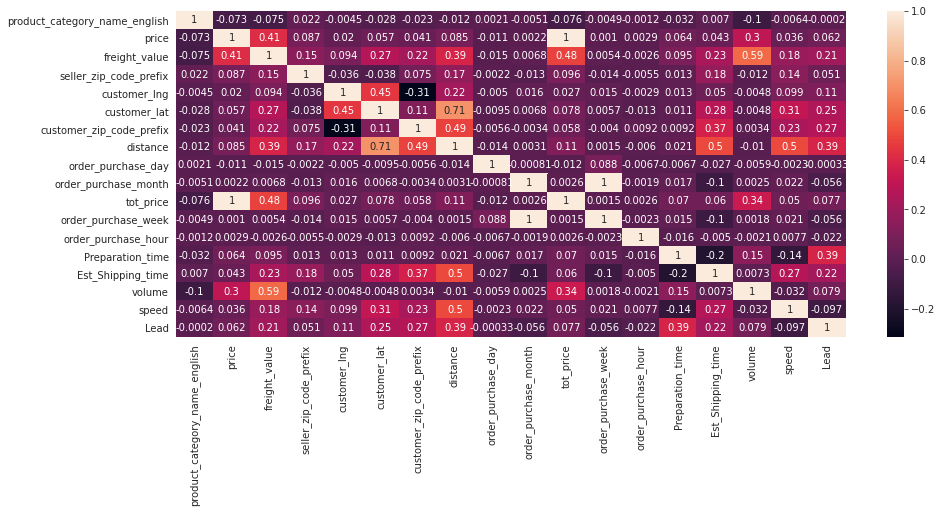

In [ ]:
plt.figure(figsize=(15,6))
sns.heatmap(olist_imp_feat.corr(),annot=True);

In [ ]:
# Check for Outliers and Null values
olist_imp_feat.isnull().sum()

product_category_name_english    0
price                            0
freight_value                    0
seller_zip_code_prefix           0
customer_lng                     0
customer_lat                     0
customer_zip_code_prefix         0
distance                         0
order_purchase_day               0
order_purchase_month             0
tot_price                        0
order_purchase_week              0
order_purchase_hour              0
Preparation_time                 0
Est_Shipping_time                0
volume                           1
speed                            0
Lead                             0
dtype: int64

In [ ]:
# Dropping null value
olist_imp_feat = olist_imp_feat.dropna()
olist_imp_feat.isnull().sum().sum()

0

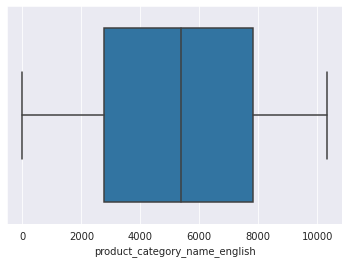

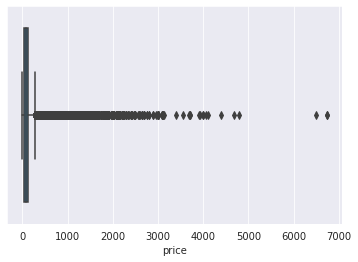

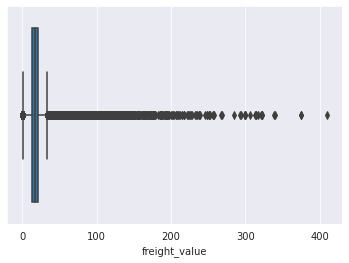

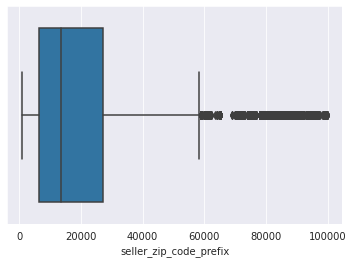

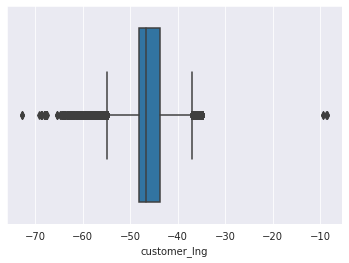

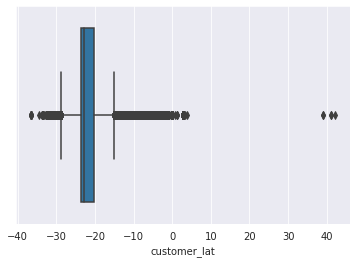

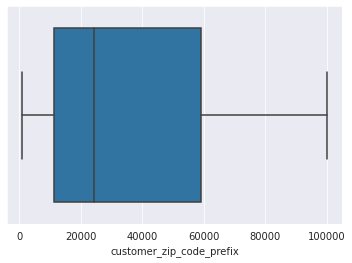

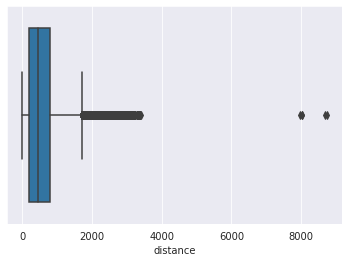

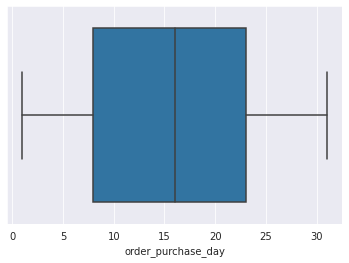

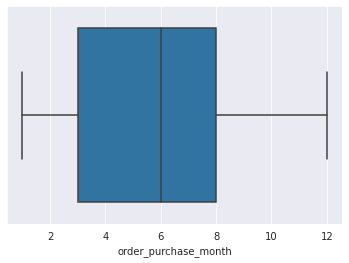

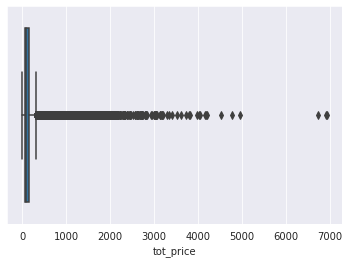

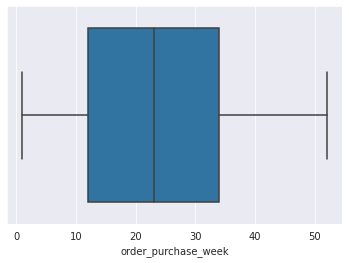

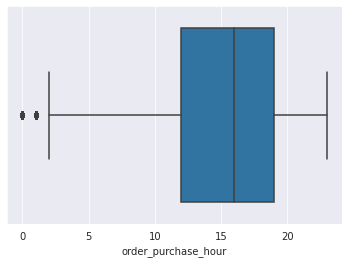

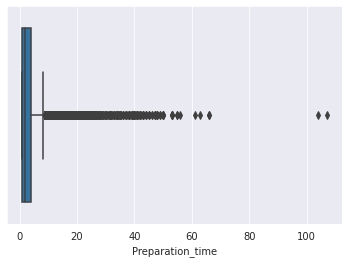

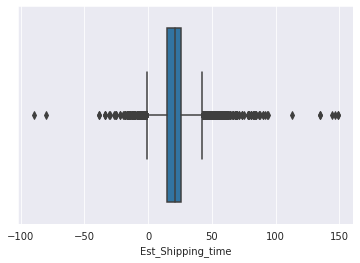

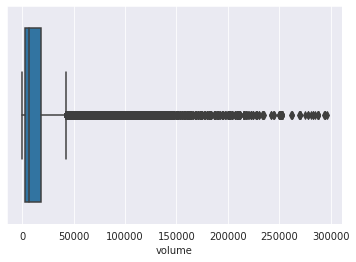

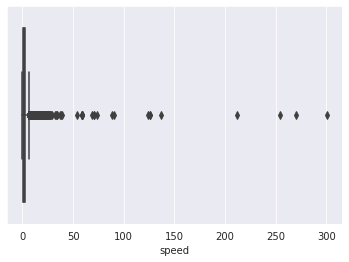

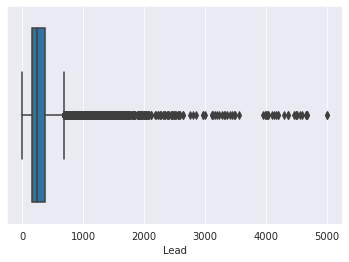

In [ ]:
# Check for outliers
for i in olist_imp_feat.columns:
  sns.boxplot(x=olist_imp_feat[i])
  plt.show()

- Most of the features has influential points/extreme values/outliers - An influential point is an outlier that greatly affects the slope of the regression line. To test the influence of an outlier we could compute the regression equation with and without the outlier.

In [ ]:
# Winscorization - Capping the outliers 

data = olist_imp_feat.copy()

for i in data.columns:
    q1=data[i].quantile(0.25)
    q3=data[i].quantile(0.75)
    iqr=q3-q1
    ub=q3 + 1.5*iqr
    lb=q1 - 1.5*iqr
    uc=data[i].quantile(0.99)
    lc=data[i].quantile(0.01)
    for ind1 in data[i].index:
        if data.loc[ind1, i] >ub:            
            data.loc[ind1, i] =uc
        if data.loc[ind1, i] < lb:
            data.loc[ind1, i] =lc

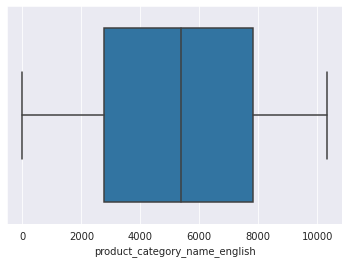

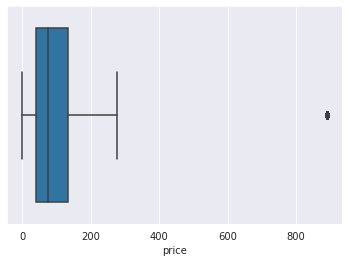

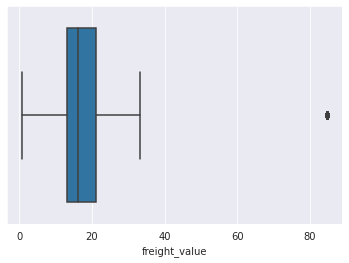

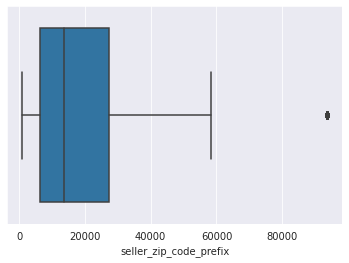

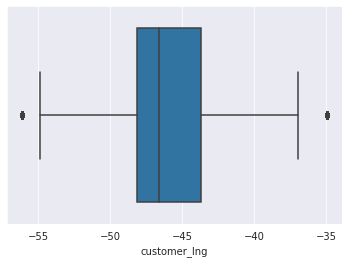

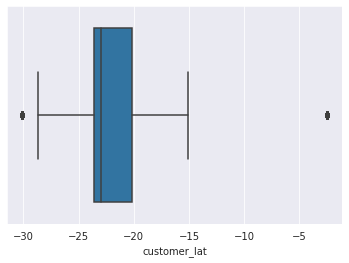

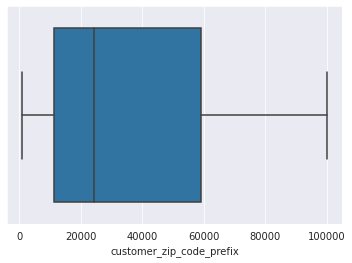

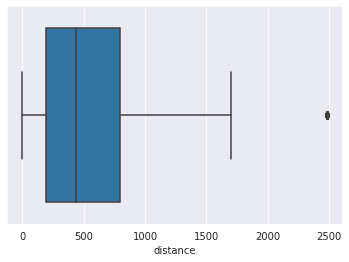

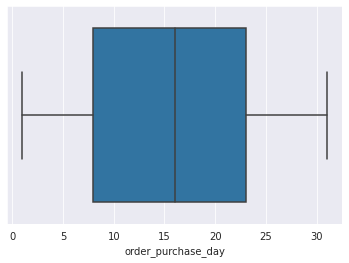

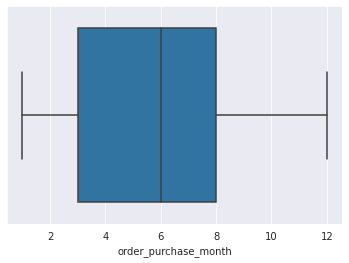

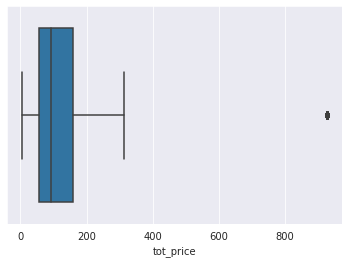

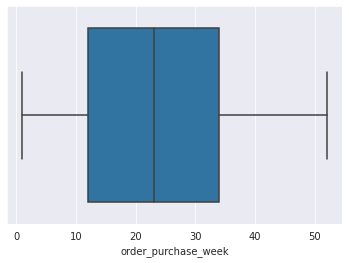

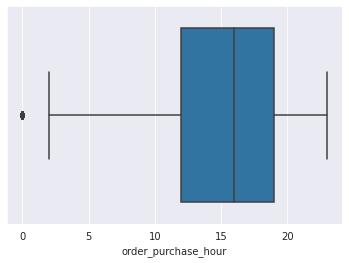

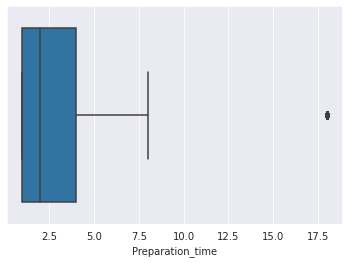

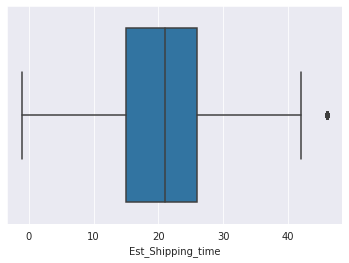

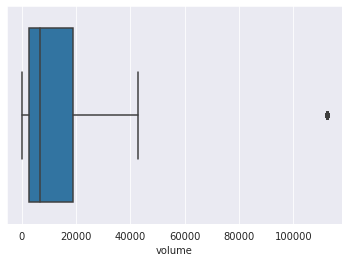

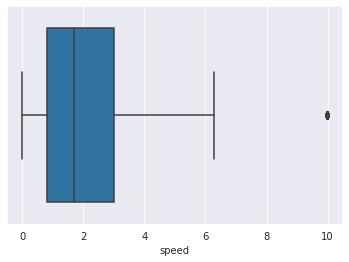

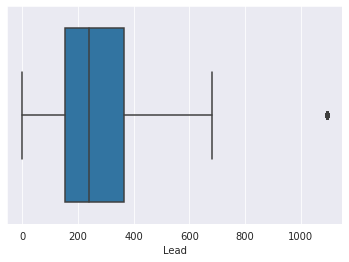

In [ ]:
# Check for outliers
for i in data.columns:
  sns.boxplot(x=data[i])
  plt.show()

## Model building
### Train test split

In [ ]:
from sklearn.preprocessing import StandardScaler,PowerTransformer,MinMaxScaler
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.feature_selection import RFECV
from sklearn.metrics import r2_score,mean_squared_error

In [ ]:
## Apply power transformer and standardisation to the input features 
## Log transformation on target feature - to satisfy linear regression assumption
x=data.drop(['Lead','volume'],axis=1)
sc=PowerTransformer(standardize=True) 
x_sc=sc.fit_transform(x)
x_sc=pd.DataFrame(x_sc,columns=x.columns,index=x.index)
y=np.log(data['Lead'])

x_train,x_test,y_train,y_test=train_test_split(x_sc,y,test_size=0.2,random_state=0)

## Base Model

In [ ]:
#Base model
import statsmodels.api as sm
from statsmodels.api import add_constant
xc=sm.add_constant(x_train)
model=sm.OLS(y_train,xc).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Lead   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                 3.797e+04
Date:                Fri, 19 Mar 2021   Prob (F-statistic):               0.00
Time:                        06:26:01   Log-Likelihood:                -1132.2
No. Observations:               80712   AIC:                             2298.
Df Residuals:                   80695   BIC:                             2456.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             5.4594      0.001   6319.839      0.000       5.458       5.461
product_category_name_english     0.0020      0.001      2.313      0.021       0.000       0.004
price                            -0.0582      0.007     -8.893      0.000      -0.071      -0.045
freight_value                     0.0102      0.001      6.940      0.000       0.007       0.013
seller_zip_code_prefix            0.0177      0.001     18.840      0.000       0.016       0.020
customer_lng                      0.0017      0.001      1.605      0.109      -0.000       0.004
customer_lat                     -0.0681      0.001    -58.997      0.000      -0.070      -0.066
customer_zip_code_prefix          0.0079      0.001      6.568      0.000       0.006       0.010
distance                          1.1286      0.002    513.749      0.000       1.124       1.133
order_purchase_day               -0.0043      0.002     -2.027      0.043      -0.008      -0.000
order_purchase_month             -0.0264      0.020     -1.289      0.197      -0.066       0.014
tot_price                         0.0627      0.007      8.976      0.000       0.049       0.076
order_purchase_week               0.0221      0.021      1.077      0.282      -0.018       0.062
order_purchase_hour              -0.0049      0.001     -5.644      0.000      -0.007      -0.003
Preparation_time                  0.0551      0.001     56.243      0.000       0.053       0.057
Est_Shipping_time                 0.0199      0.001     17.685      0.000       0.018       0.022
speed                            -0.9044      0.002   -539.791      0.000      -0.908      -0.901
==============================================================================
Omnibus:                    12311.463   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           201043.687
Skew:                          -0.153   Prob(JB):                         0.00
Kurtosis:                      10.726   Cond. No.                         64.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- After applying data treatment, From the OLS model :
- Auto correlation - serial correlation 
  - In a regression analysis, autocorrelation of the regression residuals can also occur if the model is incorrectly specified
  - Durbin-Watson:	1.986 - no auto correlation  (1.5 to 2.5)

- From the same result of OLS, we can see that multicollinearity is not present in our data, as cond no is small (<100).

-0.15314488297477818

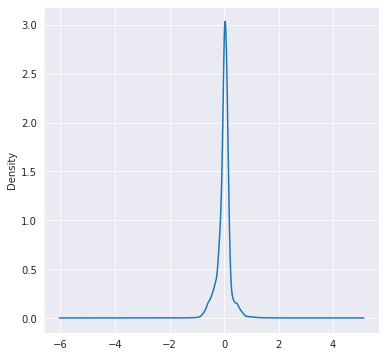

In [ ]:
# Check for Normality assumption 
plt.figure(figsize=(6,6))
model.resid.plot(kind='kde');
model.resid.skew()

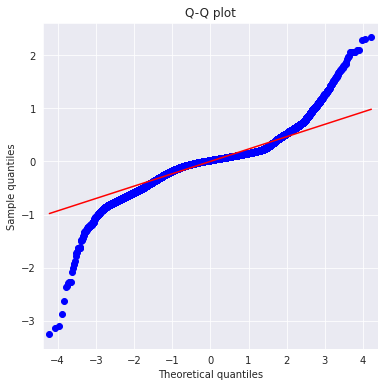

In [ ]:
from statsmodels.graphics.gofplots import qqplot
plt.rcParams['figure.figsize']=[6,6]
qqplot(model.resid,line='r')
plt.title('Q-Q plot')
plt.xlabel('Theoretical quantiles')
plt.ylabel('Sample quantiles')
plt.show()

- Skewness is -0.1 which is between -0.5 to +0.5, our residue is normal.
- At both the ends data points deviate from the regression line. Most of the points meets the straight line which suggests, residues are normal. 

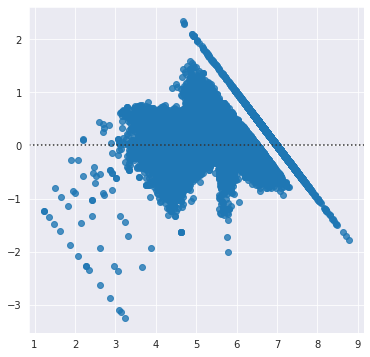

In [ ]:
# Check for Homeskedacity assumption 
#plot graph between residue and fitted values
sns.residplot(model.fittedvalues,model.resid)
plt.show()

In [ ]:
#Goldfeld-Quandt homoskedasticity test.
#This test examines whether the residual variance is the same in 2 subsamples.
from statsmodels.stats.api import het_goldfeldquandt
# The Null hypothesis is that the variance in the two sub-samples are the same. The alternative hypothesis, can be increasing, 
#i.e. the variance in the second sample is larger than in the first, or decreasing or two-sided.

## Homoscedacity.

# H0 : There is homoscedasticity present in the data.
# Ha : There is a heteroscedasticity present in the data.
het_goldfeldquandt(y_train,xc)

(0.9918007597509607, 0.7958188290519543, 'increasing')

- pval > 0.05, so there is homoscedasticity present in the data.
- Also, the plot suggest that the error terms are randomly distributed, there is no Funnel/cone formation.

In [ ]:
# Check for Linearity assumption
#linear rainbow test - atleast 50% of data is linear input and residue 
from statsmodels.stats.diagnostic import linear_rainbow
#h0 : part of the data is linear
linear_rainbow(res=model,frac=0.5) #0.5 - atleast 50% #returns fstat and pvalue

(0.9834445615360743, 0.9531914397804178)

- pval > 0.05 - fail to reject null hyp, atleast 50% of data is linear 

### Base Model Observations
- Base Model and Assumptions are done. R2 value is 0.883 and except customer long, order purchase month and week, all the other features are significant.

### Scope of Improvement 
- Feature selection, Regularization models, Other Tree based models and Ensemble techniques.

## Feature Selection - RFE

In [ ]:
model = LinearRegression()
rfe = RFECV(model,scoring = 'neg_mean_squared_error')
rfe_mod = rfe.fit(x_train,y_train)
rfe_rank = pd.DataFrame()
rfe_rank['Features'] = x_train.columns
rfe_rank['rank'] = rfe_mod.ranking_
feat_rfe=rfe_rank[rfe_rank['rank']==1]['Features']
feat_rfe=list(feat_rfe)
print(feat_rfe)
print(len(feat_rfe))

['product_category_name_english', 'price', 'freight_value', 'seller_zip_code_prefix', 'customer_lng', 'customer_lat', 'customer_zip_code_prefix', 'distance', 'order_purchase_day', 'order_purchase_month', 'tot_price', 'order_purchase_week', 'order_purchase_hour', 'Preparation_time', 'Est_Shipping_time', 'speed']
16


- Using RFECV, model chooses all the 16 features as significant to create a Linear Regression models.

## Linear Regression model

In [ ]:
lr=LinearRegression()
lr.fit(x_train,y_train)
ypred_train=lr.predict(x_train)
ypred_test=lr.predict(x_test)

r2_train=r2_score(y_train,ypred_train)
r2_test=r2_score(y_test,ypred_test)

rmse_train= np.sqrt(mean_squared_error(y_train,ypred_train))
rmse_test= np.sqrt(mean_squared_error(y_test,ypred_test))

res_rfe=[r2_train,r2_test,rmse_train,rmse_test]
res_rfe

[0.8827518842756561,
 0.8816731502832617,
 0.24538894603634576,
 0.24666694106206616]

In [ ]:
# Inverse transformation of LOG - using exponential and calculate RMSE
print("Predictions : ", np.exp(ypred_test))
print("Actual : ", np.exp(y_test))

Predictions :  [174.51220013 124.2660363  193.85071528 ... 339.62436647 177.12154365
 860.48897798]
Actual :  21450      163.0
80071      138.0
107702     200.0
6618       248.0
31417      166.0
           ...  
98750      473.0
105898     247.0
67509      341.0
89140      184.0
29781     1093.0
Name: Lead, Length: 20179, dtype: float64


In [ ]:
## RMSE for Base Model
lin_mse = mean_squared_error(np.exp(y_test), np.exp(ypred_test))
lin_rmse = np.sqrt(lin_mse)
print('RMSE for LinearRegression Model',lin_rmse)

RMSE for LinearRegression Model 130.26403871709954


## Cross Validation on different models

## Linear Regression

In [ ]:
## Cross validation - 5 folds

lr=LinearRegression()
score=cross_val_score(lr,x_train,y_train,cv=5,scoring='neg_mean_squared_error')
score=np.sqrt(abs(score))
avg_score=np.mean(score)
ve=np.std(score)
cve=np.std(score)/np.mean(score)
print(avg_score,ve,cve) # 0.8% variance error in terms of RMSE ( deviations are about 0.8%)

0.24545809201501592 0.0020058456587056963 0.008171845720136163


## Ridge Regularization

In [ ]:
## Cross validation - 5 folds

ridge=Ridge()
score=cross_val_score(ridge,x_train,y_train,cv=5,scoring='neg_mean_squared_error')
score=np.sqrt(abs(score))
avg_score=np.mean(score)
ve=np.std(score)
cve=np.std(score)/np.mean(score)
print(avg_score,ve,cve) # 0.8% variance error in terms of RMSE ( deviations are about 0.8%)

0.24545798365740107 0.002004949468011362 0.008168198231473205


## Lasso Regularization

In [ ]:
## Cross validation - 5 folds

lasso=Lasso()
score=cross_val_score(lasso,x_train,y_train,cv=5,scoring='neg_mean_squared_error')
score=np.sqrt(abs(score))
avg_score=np.mean(score)
ve=np.std(score)
cve=np.std(score)/np.mean(score)
print(avg_score,ve,cve) # 0.1% variance error in terms of RMSE ( deviations are about 0.1%, has problem of overfitting)

0.7166460994498552 0.001132083362976881 0.0015796965389833879


## Decision Tree Regressor

In [ ]:
## Cross validation - 5 folds
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
score=cross_val_score(tree_reg,x_train,y_train,cv=5,scoring='neg_mean_squared_error')
score=np.sqrt(abs(score))
avg_score=np.mean(score)
ve=np.std(score)
cve=np.std(score)/np.mean(score)
print(avg_score,ve,cve) # 3% variance error in terms of RMSE (deviations are about 3%, has problem of overfitting)

0.1113756207270948 0.004407395836506444 0.03957235710771881


## Random Forest Regressor

In [ ]:
## Cross validation - 5 folds
from sklearn.ensemble import RandomForestRegressor

RF_reg = RandomForestRegressor()
score=cross_val_score(RF_reg,x_train,y_train,cv=5,scoring='neg_mean_squared_error')
score=np.sqrt(abs(score))
avg_score=np.mean(score)
ve=np.std(score)
cve=np.std(score)/np.mean(score)
print(avg_score,ve,cve) # 3% variance error in terms of RMSE ( deviations are about 3%, has problem of overfitting)

0.07841918525698278 0.0024420063975874548 0.03114042041606149


## Gradient descent

In [ ]:
## Cross validation - 5 folds
from sklearn.linear_model import SGDRegressor


sgd = SGDRegressor()
score=cross_val_score(sgd,x_train,y_train,cv=5,scoring='neg_mean_squared_error')
score=np.sqrt(abs(score))
avg_score=np.mean(score)
ve=np.std(score)
cve=np.std(score)/np.mean(score)
print(avg_score,ve,cve) # less ve

0.24583612482929454 0.0020184383735484834 0.008210503541536303


- From the above models, Random Forest model results in less RMSE and hence building an Random Forest Regressor model and tuning it for better results.
- Yet, the model is overfitted with variance error. So, Model tuning and pruning has to be done.

In [ ]:
# Grid Search CV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

params={'n_estimators':[50,80,100,120,140,190,200,210]
        'max_depth':[10,15,20,25,30,40]}

In [ ]:
rf_mod1=RandomForestRegressor()
hyp_mod=GridSearchCV(rf_mod1,param_grid=params,cv=5,scoring='neg_mean_squared_error',n_jobs=-1)

In [ ]:
tun_mod=hyp_mod.fit(x_train,y_train) 

In [ ]:
tun_mod.best_params_

{'max_depth': 25, 'n_estimators': 200}

In [ ]:
tun_mod.best_score_

-0.006062602038050433

In [ ]:
final_mod=RandomForestRegressor(max_depth=25, max_features='auto',
                      n_estimators=200, n_jobs=-1, oob_score=True,random_state=0)

In [ ]:
final_mod.fit(x_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=25, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=-1, oob_score=True,
                      random_state=0, verbose=0, warm_start=False)

In [ ]:
final_mod.oob_score_

0.9889236631078376

In [ ]:
ypred_train=final_mod.predict(x_train)
ypred_test=final_mod.predict(x_test)

r2_train=r2_score(y_train,ypred_train)
r2_test=r2_score(y_test,ypred_test)

rmse_train= np.sqrt(mean_squared_error(y_train,ypred_train))
rmse_test= np.sqrt(mean_squared_error(y_test,ypred_test))

print(r2_train,r2_test,rmse_train,rmse_test)

0.9983980513599637 0.9903309527587444 0.028683117589672267 0.07051169231605181


In [ ]:
# Inverse transformation of LOG - using exponential and calculate RMSE
print("Predictions : ", np.exp(ypred_test))
print("Actual : ", np.exp(y_test))

Predictions :  [ 163.          137.90404212  198.25066586 ...  340.82817839  184.72574638
 1093.        ]
Actual :  21450      163.0
80071      138.0
107702     200.0
6618       248.0
31417      166.0
           ...  
98750      473.0
105898     247.0
67509      341.0
89140      184.0
29781     1093.0
Name: Lead, Length: 20179, dtype: float64


In [ ]:
## RMSE for Final Model
lin_mse = mean_squared_error(np.exp(y_test), np.exp(ypred_test))
lin_rmse = np.sqrt(lin_mse)
print('RMSE for Random Forest - Tuned Model',lin_rmse)

RMSE for Random Forest - Tuned Model 31.769040078055248


In [ ]:
feat=pd.DataFrame({'feature':x_train.columns,
                   'feat_imp':final_mod.feature_importances_})
feat.sort_values('feat_imp',ascending=False)


,feature,feat_imp
7,distance,0.545699
15,speed,0.372554
13,Preparation_time,0.069167
6,customer_zip_code_prefix,0.002209
3,seller_zip_code_prefix,0.001188
4,customer_lng,0.001172
2,freight_value,0.001067
8,order_purchase_day,0.000996
0,product_category_name_english,0.000992
14,Est_Shipping_time,0.000968


## **Conclusion**
- Final model is Random Forest Regressor, RMSE is 31 and the impotant feature which determins the Lead time is Distance, Speed, Preparation time, Customer and seller Location, Freight value.
- So, when a new order comes in, using the Random Forest model, Lead Time can be predicted. This way, Delivery can be speed up according to the predictions. 
- The major benefits of reducing lead times are reduced carrying costs, streamlined operations, and improved productivity. This in-turn helps to improve customer satisfaction and retention.